<a href="https://colab.research.google.com/github/Loki-10/Inframind-Edge_Computing/blob/master/Edge_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!git clone https://github.com/tensorflow/models/

In [0]:
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install utils
!pip install opencv-python
!pip install tensorflow-gpu
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools

In [0]:
!pip install tensorflow-gpu==1.14.0
!pip install tensorboard==1.14.0
!pip install tensorflow-estimator==1.14.0

In [0]:
%cd /content/models/research

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

In [0]:
!python3 setup.py build
!python3 setup.py install

In [0]:
%cd /

In [0]:
!cp -avr /content/drive/My\ Drive/object-detection /content

In [0]:
 %cd /content/object-detection

In [0]:
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=images/train

In [0]:
!python3 generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/test

In [0]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
!tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
!cp -avr /content/object-detection/data /content/models/research/object_detection

In [0]:
!cp -avr /content/object-detection/images /content/models/research/object_detection

In [0]:
!cp -avr /content/object-detection/faster_rcnn_inception_v2_coco_2018_01_28 /content/models/research/object_detection

In [0]:
!cp -avr /content/drive/My\ Drive/training /content/models/research/object_detection

In [0]:
%cd /content/models/research/object_detection

In [0]:
!python3 export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path training/faster_rcnn_inception_v2_coco.config \
    --trained_checkpoint_prefix training/model.ckpt-21602\
    --output_directory edge_compute_model

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [0]:
%matplotlib inline

In [0]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
MODEL_NAME = 'edge_compute_model'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

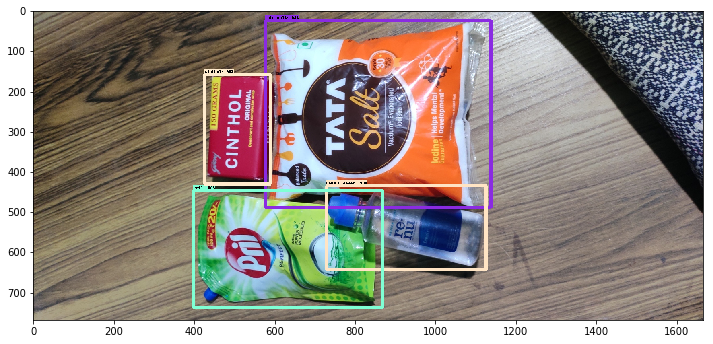

In [228]:
image = Image.open('/content/models/research/object_detection/test_images/3.jpg')
image_np = load_image_into_numpy_array(image)
image_np_expanded = np.expand_dims(image_np, axis=0)
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=(12, 8))
plt.imshow(image_np)

In [232]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
#print([category_index.get(i) for i in classes[0]])
final_score= np.squeeze(scores)    
count=0
for i in range(100):
  if scores is None or final_score[i] > 0.5:
    count=count+1
for i in range(count):
  print(category_index[classes[0][i]]) 

{'id': 8, 'name': 'Tata Salt'}
{'id': 6, 'name': 'Lens Cleaner'}
{'id': 3, 'name': 'Pril'}
{'id': 7, 'name': 'Cinthol'}


In [233]:
for i in range(count):
  print(category_index[classes[0][i]]["name"])

Tata Salt
Lens Cleaner
Pril
Cinthol
